# AORC Data

DayMet's API has recently gone down, leading us to experiment with a new type of met data, AORC, which is the dataset used to drive the National Water Model.


In [1]:
%load_ext autoreload
%autoreload 2

AORC provides gridded meteorological data for the conterminous US and Alaska at ~800m spatial resolution with hourly timestep from 1979 (Conterminous US) or 1981 (Alaska) ~ present. [website](https://registry.opendata.aws/noaa-nws-aorc/)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| APCP_surface | Total precipitation [mm] |
| DLWRF_surface | Incident longwave radiation flux density [W m^-2] |
| DSWRF_surface | Incident shortwave radiation flux density [W m^-2]  |
| PRES_surface | Air pressure [Pa]  |
| SPFH_2maboveground   | Specific Humidity [g/g] |
| TMP_2maboveground | Air temperature [°C]|
| UGRD_10maboveground | West-East component of the wind velocity [m s^-1] |
| VGRD_10maboveground | North-South component of the wind velocity [m s^-1] |

Notes:
 - AORC, unlike DayMet, provides all Gregorian calendar days 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
import logging
import numpy as np
import os
import cftime, datetime
import pickle

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources
import watershed_workflow.meteorology
import watershed_workflow.io

watershed_workflow.ui.setup_logging(1,None)

In [4]:
out_files_path = './intermediate_files/output_files.pkl'
with open(out_files_path, 'rb') as f:
    output_filenames = pickle.load(f)
display(output_filenames)

{'nlcd_indices': [21, 22, 23, 41, 42, 43, 81],
 'nlcd_labels': ['Developed, Open Space',
  'Developed, Low Intensity',
  'Developed, Medium Intensity',
  'Deciduous Forest',
  'Evergreen Forest',
  'Mixed Forest',
  'Pasture/Hay'],
 'modis_lai_transient': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_transient.h5',
 'modis_lai_cyclic_steadystate': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5',
 'nlcd_lai_cyclic_steadystate': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5',
 'nlcd_lai_transient': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_2010_2011.h5',
 'subsurface_properties': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_subsurface_properties.csv',
 'mesh': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta.exo'}

In [5]:
start = "2010-10-1"
end = "2011-09-30"

output_filenames['start'] = start
output_filenames['end'] = end

In [6]:
data_dir = './input_data'
watershed_workflow.config.setDataDirectory(data_dir)

In [7]:
name = 'Coweeta'
coweeta_shapefile = os.path.join('input_data', 'coweeta_basin.shp')

In [8]:
# coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
crs = watershed_workflow.crs.default_crs

## Load the Watershed

In [9]:
# intermediate_dir = './intermediate_files/'
# with open(f'{intermediate_dir}watershed.pkl', 'rb') as file:
#     watershed = pickle.load(file)
# watershed.plot()

2025-09-03 17:53:04,417 - root - INFO: fixing column: geometry
2025-09-03 17:53:04,421 - root - INFO: Removing holes on 1 polygons
2025-09-03 17:53:04,421 - root - INFO:   -- removed interior
2025-09-03 17:53:04,422 - root - INFO:   -- union
2025-09-03 17:53:04,422 - root - INFO: Parsing 1 components for holes
2025-09-03 17:53:04,422 - root - INFO:   -- complete


<Axes: >

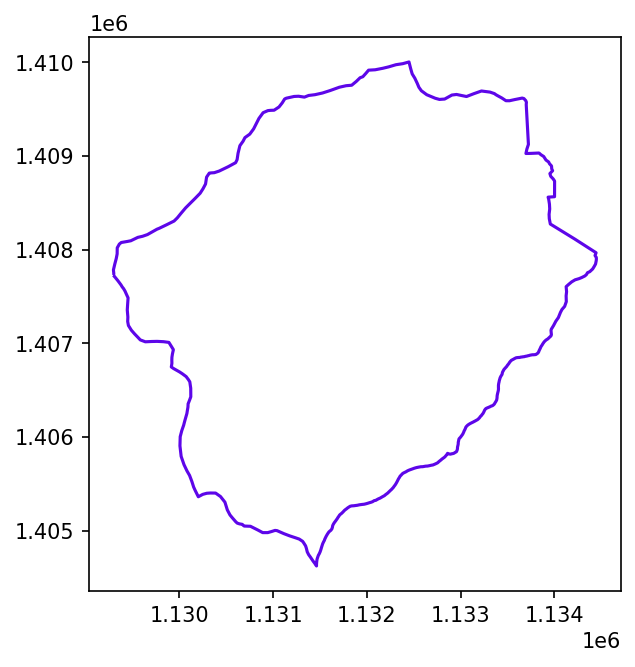

In [10]:
coweeta_source = watershed_workflow.sources.ManagerShapefile(coweeta_shapefile, id_name='BASIN_CODE')
coweeta = coweeta_source.getShapes(out_crs=crs)

watershed = watershed_workflow.SplitHUCs(coweeta)
watershed_workflow.split_hucs.simplify(watershed, 60)
watershed.plot()

## Download the raw AORC raster

returned raw data has `dim(nband, ncol, nrow)`

In [11]:
# setting vars = None to download all available variables
source = watershed_workflow.sources.ManagerAORC()
met_data = source.getDataset(coweeta, start=start, end=end)

2025-09-03 17:53:04,480 - root - INFO: Incoming shape area = 0.00160586024725798
2025-09-03 17:53:04,480 - root - INFO: ... buffering incoming shape by = 0.00833333
2025-09-03 17:53:04,483 - root - INFO: ... buffered shape area = 0.0032218648325563733


  Using existing: ./input_data/meteorology/aorc/aorc_2010-2011_35.0822x-83.4133_35.019x-83.4868.nc


## Warp the dataset

AORC comes back as a non-projected dataset in lat-lon.  We need to warp it to a projected dataset for use in ATS.

In [12]:
met_data_warped = watershed_workflow.warp.dataset(met_data, crs, 'bilinear')

## Save to Disk

### NetCDF file

By default, the raw data is saved to $DATA_DIR/meteorology/aorc/ in a netcdf file.


### Write to ATS format

This will write AORC in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [13]:
# convert the data to ATS units, partitioning precip into rain and snow, and computing daily averages
met_data_ats = watershed_workflow.meteorology.convertAORCToATS(met_data_warped)

start_year = datetime.datetime.strptime(start, "%Y-%m-%d").year
end_year = datetime.datetime.strptime(end, "%Y-%m-%d").year

filename = os.path.join('.', 'output_data', f'{name}_AORC-{start_year}-{end_year}.h5')
output_filenames['meteorology_transient'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_ats,
    met_data_ats.attrs)
    

2025-09-03 17:53:04,845 - root - INFO: Converting AORC to ATS met input
2025-09-03 17:53:04,862 - root - INFO: Writing HDF5 file: ./output_data/Coweeta_AORC-2010-2011.h5


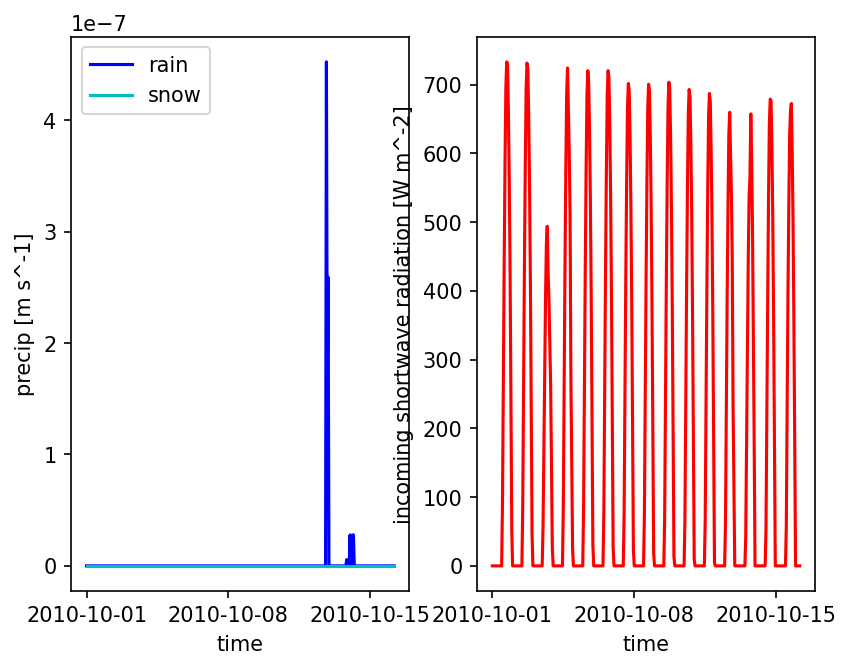

In [14]:
# plot one pixel as a function of time
fig = plt.figure()
ax = fig.add_subplot(121)

met_data_single_pixel = met_data_ats.isel({'time':slice(0,365),
                                           'x' : 5,
                                           'y' : 5})

met_data_single_pixel['precipitation rain [m s^-1]'].plot(color='b', label='rain')
met_data_single_pixel['precipitation snow [m SWE s^-1]'].plot(color='c', label='snow')
ax.set_ylabel('precip [m s^-1]')
ax.set_title('')
ax.legend()

ax = fig.add_subplot(122)
met_data_single_pixel['incoming shortwave radiation [W m^-2]'].plot(color='r', label='qSW_in')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
ax.set_title('')

plt.show()

## Smooth to form a typical year
A "typical" year is commonly used in a cyclic, annual steady-state spinup. We form this by averaging all Jan 1s in the record, averaging all Jan 2s, etc.

In [15]:
met_data

<xarray.Dataset> Size: 35MB
Dimensions:              (time: 8737, latitude: 7, longitude: 9)
Coordinates:
  * latitude             (latitude) float64 56B 35.02 35.03 ... 35.07 35.07
  * longitude            (longitude) float64 72B -83.49 -83.48 ... -83.43 -83.42
  * time                 (time) object 70kB 2010-10-01 00:00:00 ... 2011-09-3...
Data variables:
    APCP_surface         (time, latitude, longitude) float64 4MB ...
    DLWRF_surface        (time, latitude, longitude) float64 4MB ...
    DSWRF_surface        (time, latitude, longitude) float64 4MB ...
    PRES_surface         (time, latitude, longitude) float64 4MB ...
    SPFH_2maboveground   (time, latitude, longitude) float64 4MB ...
    TMP_2maboveground    (time, latitude, longitude) float64 4MB ...
    UGRD_10maboveground  (time, latitude, longitude) float64 4MB ...
    VGRD_10maboveground  (time, latitude, longitude) float64 4MB ...
Attributes:
    name:     AORC v1.1
    source:   NOAA AWS S3 Zarr

In [16]:
# aggregate to daily data
met_data_daily = met_data.resample(time=datetime.timedelta(hours=24)).mean()

ndays = met_data_daily['APCP_surface'].shape[0]
print('nyears = ', ndays // 365)
print('n days leftover = ', ndays % 365)
print('note, that leftover day is a leap day')


nyears =  1
n days leftover =  0
note, that leftover day is a leap day


In [17]:
# cannot compute a typical year for leap year -- need to align days-of-the-year

# remove leap day (Dec 31 of leap years)
met_data_noleap = watershed_workflow.data.filterLeapDay(met_data_daily)

# smooth the raw data
met_data_smooth = watershed_workflow.data.smoothTimeSeries(met_data_noleap, method='savgol', window_length=181, polyorder=2)

# then compute a "typical" year
met_data_typical = watershed_workflow.data.computeAverageYear(met_data_smooth, 'time', 2010, 2)

# then reproject
met_data_typical_warped = watershed_workflow.warp.dataset(met_data_typical, crs, 'bilinear')

# and lastly convert to ATS
met_data_typical_ats = watershed_workflow.meteorology.convertAORCToATS(met_data_typical_warped)

2025-09-03 17:53:12,690 - root - INFO: Converting AORC to ATS met input


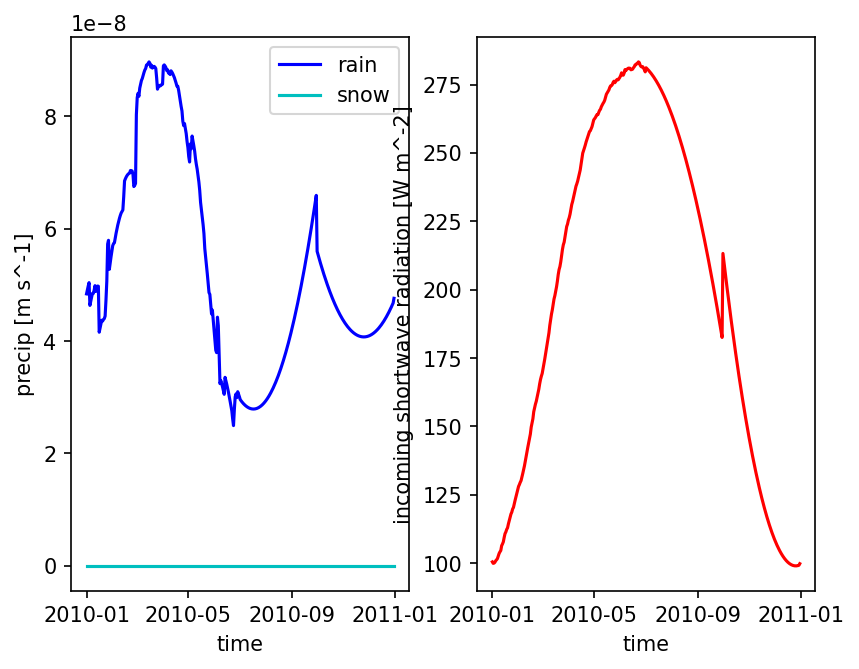

In [18]:
# plot one pixel as a function of time
fig = plt.figure()
ax = fig.add_subplot(121)

met_data_single_pixel = met_data_typical_ats.isel({'time':slice(0,365),
                                           'x' : 5,
                                           'y' : 5})

met_data_single_pixel['precipitation rain [m s^-1]'].plot(color='b', label='rain')
met_data_single_pixel['precipitation snow [m SWE s^-1]'].plot(color='c', label='snow')
ax.set_ylabel('precip [m s^-1]')
ax.set_title('')
ax.legend()

ax = fig.add_subplot(122)
met_data_single_pixel['incoming shortwave radiation [W m^-2]'].plot(color='r', label='qSW_in')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
ax.set_title('')

plt.show()

In [19]:
# write cyclic steadystate data to disk
filename = os.path.join('.', 'output_data', f'{name}_AORC-CyclicSteadystate.h5')
output_filenames['meteorology_cyclic_steadystate'] = filename
watershed_workflow.io.writeDatasetToHDF5(
    filename,
    met_data_typical_ats,
    met_data_typical_ats.attrs)


2025-09-03 17:53:12,778 - root - INFO: Writing HDF5 file: ./output_data/Coweeta_AORC-CyclicSteadystate.h5


In [20]:
precip_mean = (met_data_ats['precipitation rain [m s^-1]'].data + met_data_ats['precipitation snow [m SWE s^-1]'].data).mean()
logging.info(f'Mean precip value = {precip_mean}')

2025-09-03 17:53:13,373 - root - INFO: Mean precip value = 5.051745545169705e-08


In [21]:
output_filenames['mean_precip [m s^-1]'] = float(precip_mean)

In [22]:
display(output_filenames)
with open(out_files_path, 'wb') as f:
    pickle.dump(output_filenames, f)

{'nlcd_indices': [21, 22, 23, 41, 42, 43, 81],
 'nlcd_labels': ['Developed, Open Space',
  'Developed, Low Intensity',
  'Developed, Medium Intensity',
  'Deciduous Forest',
  'Evergreen Forest',
  'Mixed Forest',
  'Pasture/Hay'],
 'modis_lai_transient': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_transient.h5',
 'modis_lai_cyclic_steadystate': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_MODIS_CyclicSteadystate.h5',
 'nlcd_lai_cyclic_steadystate': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_CyclicSteadystate.h5',
 'nlcd_lai_transient': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_LAI_NLCD_2010_2011.h5',
 'subsurface_properties': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta_subsurface_properties.csv',
 'mesh': '/home/joyvan/workdir/ats-short-course/05_model_setup/output_data/Coweeta.exo',
 'start': '2010-10-1',
 'end'

### Other choices for Precip

Often smoothing precip like that is a bad idea -- you now have every day misting with low intensity rain which can result in a ton of interception
and canopy evaporation and no transpiration.  Another approach is to just take the median total rainfall year and repeat that year multiple times.

In [23]:
met_data_noleap['APCP_surface'].shape[0] % 365

0

In [24]:
precip_raw = met_data_noleap['APCP_surface']
shape_xy = precip_raw.shape[1:]

precip_raw = precip_raw.values.reshape((-1, 365,)+shape_xy)
annual_precip_raw = precip_raw.sum(axis=(1,2,3))
print(annual_precip_raw)


[5194.15424407]


In [25]:
# find the median...
# note -- don't use np.median here... for even number of years it will not appear.  Instead, sort and take the halfway point
median_i = sorted(((i,v) for (i,v) in enumerate(annual_precip_raw)), key=lambda x : x[1])[len(annual_precip_raw)//2][0]

spatially_averaged_typical_year_precip = precip_raw[median_i]
spatially_averaged_typical_year_precip.shape


(365, 7, 9)

In [26]:
# stuff the median year into the typical data, tiled for number of years being generated (here 2)
typical_precip_raw = np.tile(precip_raw[median_i], (2,1,1))
met_data_typical['APCP_surface'] = (['time', 'latitude', 'longitude'], typical_precip_raw)

In [27]:
# then reproject
met_data_typical_warped = watershed_workflow.warp.dataset(met_data_typical, crs, 'bilinear')

# convert that to ATS
met_data_typical_ats = watershed_workflow.meteorology.convertAORCToATS(met_data_typical_warped)


2025-09-03 17:53:13,555 - root - INFO: Converting AORC to ATS met input


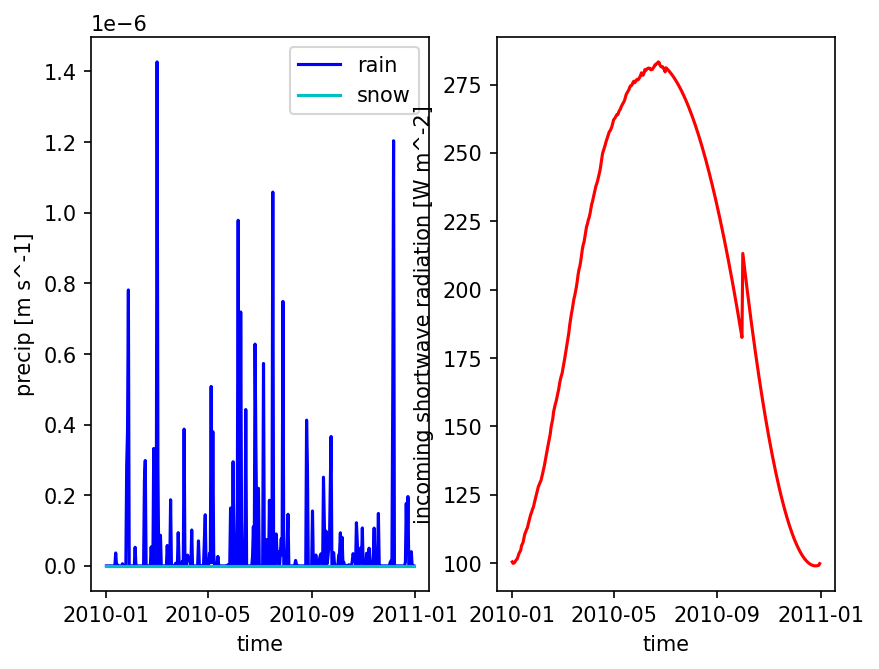

In [28]:
# plot one pixel as a function of time
fig = plt.figure()
ax = fig.add_subplot(121)

met_data_single_pixel = met_data_typical_ats.isel({'time':slice(0,365),
                                           'x' : 5,
                                           'y' : 5})

met_data_single_pixel['precipitation rain [m s^-1]'].plot(color='b', label='rain')
met_data_single_pixel['precipitation snow [m SWE s^-1]'].plot(color='c', label='snow')
ax.set_ylabel('precip [m s^-1]')
ax.set_title('')
ax.legend()

ax = fig.add_subplot(122)
met_data_single_pixel['incoming shortwave radiation [W m^-2]'].plot(color='r', label='qSW_in')
ax.set_ylabel('incoming shortwave radiation [W m^-2]')
ax.set_title('')

plt.show()